**Task: Create FPR/FNR/Accuracy graphs for different mixing rates for the Folktable**


Custom Prediction Task: ACSIncomeNew : Income greater the $50k on target SEX from ACS 2018 Data for CA

total Females in dataset:  92354
fixed training set size:  46200


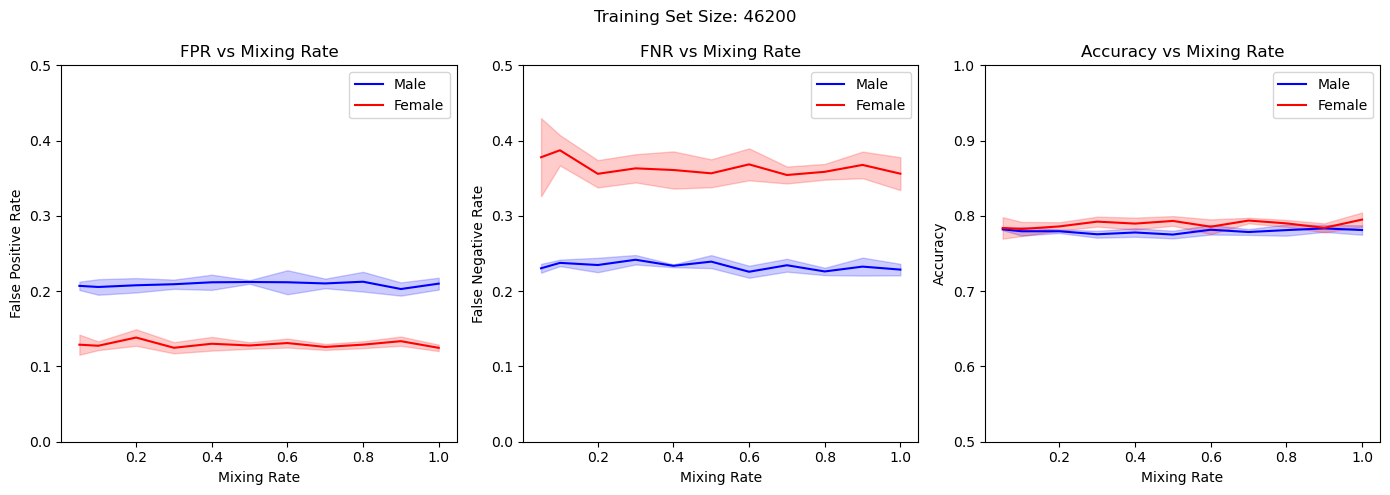

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import folktables
from folktables import ACSDataSource

def calculate_metrics(y_true, y_pred):
    # Check if the confusion matrix is empty
    if np.sum(y_true == 1) == 0 or np.sum(y_true == 0) == 0:
        fpr, fnr, acc = np.nan, np.nan, np.nan
    else:
        # Calculate confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        # Extract values from the confusion matrix
        tn, fp, fn, tp = cm.ravel()
        fpr = fp / (fp + tn)
        fnr = fn / (fn + tp)
        acc = accuracy_score(y_true, y_pred)
    return fpr, fnr, acc

ACSIncomeNew = folktables.BasicProblem(
    features=[
        'AGEP', 
        'COW', 
        'SCHL', 
        'MAR', 
        'OCCP', 
        'POBP', 
        'RELP', 
        'WKHP', 
        'SEX', 
        'RAC1P',
    ],
    target='PINCP',
    target_transform=lambda x: x > 50000,
    group='SEX',
    preprocess=folktables.adult_filter,
    postprocess=lambda x: np.nan_to_num(x, -1),
)

def evaluate_model_with_mixing_rate_and_size(mixing_rate, modified_size, features, labels, groups):
    # Calculate the initial size of the dataset
    initial_size = len(features)
#     print("Initial size", initial_size)
#     num_males_original = np.sum(groups == 1)
#     print("Number of Males Original", num_males_original)
#     num_females_original = np.sum(groups == 2)
#     print("Number of Females Original", num_females_original)


    # Adjust the mixing rate by subsampling the 'female' group
    female_indices = np.where(groups == 2)[0]
    num_female_to_keep = int(len(female_indices) * mixing_rate)
    subsampled_female_indices = np.random.choice(female_indices, size=num_female_to_keep, replace=False)

    # Create the modified dataset
    modified_features = np.concatenate([features[groups == 1], features[subsampled_female_indices]])
    modified_labels = np.concatenate([labels[groups == 1], labels[subsampled_female_indices]])
    modified_groups = np.concatenate([groups[groups == 1], groups[subsampled_female_indices]])

    # If the modified size is specified, subsample to the desired size
    if modified_size is not None and modified_size < len(modified_features):
        subsample_indices = np.random.choice(np.arange(len(modified_features)), size=modified_size, replace=False)
        modified_features = modified_features[subsample_indices]
        modified_labels = modified_labels[subsample_indices]
        modified_groups = modified_groups[subsample_indices]

    # Split the modified dataset into train and test sets
    X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
        modified_features, modified_labels, modified_groups, test_size=0.2, random_state=0)

    # Create and fit the model
    model = make_pipeline(StandardScaler(), LogisticRegression())
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate FPR, FNR, and Accuracy for male (group = 1) and female (group = 2)
    fpr_male, fnr_male, acc_male = calculate_metrics(y_test[group_test == 1], y_pred[group_test == 1])
    fpr_female, fnr_female, acc_female = calculate_metrics(y_test[group_test == 2], y_pred[group_test == 2])

    return initial_size, modified_size, num_males_original, num_females_original, len(modified_features), \
           fpr_male, fnr_male, acc_male, fpr_female, fnr_female, acc_female

data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_ca = data_source.get_data(states=["CA"], download=True)
ca_features, ca_label, ca_group = ACSIncomeNew.df_to_numpy(acs_ca)

# Split data for training
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    ca_features, ca_label, ca_group, test_size=0.3, random_state=0)

# Train the model
model = make_pipeline(StandardScaler(), LogisticRegression())
model.fit(X_train, y_train)

mixing_rates = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
# modified_sizes = [4000, 8000, 10000]

totalFemales = len(np.where(ca_group == 2)[0])
print("total Females in dataset: ", totalFemales)

# fix training set size to 0.5 * Females, round to nearest multiple of 100
fixed_train_size = int(round(0.5 * totalFemales, -2))
print("fixed training set size: ", fixed_train_size)

# fixed_train_set_size = 0.5 * num_females_original

results = {'Mixing Rate': [], 'Initial Size': [], 'Modified Size': [], 'Num Males Original': [],
           'Num Females Original': [], 'FPR Male': [], 'FNR Male': [], 'Accuracy Male': [],
           'FPR Female': [], 'FNR Female': [], 'Accuracy Female': []}

# Separate graphs for FPR, FNR, and Accuracy for each training set size
# for modified_size in modified_sizes:# ... (previous code)

# Separate graphs for FPR, FNR, and Accuracy for each training set size
# for modified_size in modified_sizes:
results_subset_list = []  # List to store results of each iteration
num_iterations = 5
for _ in range(num_iterations):  # Set the number of iterations
    results_subset = {'Mixing Rate': [], 'FPR Male': [], 'FNR Male': [], 'Accuracy Male': [],
                      'FPR Female': [], 'FNR Female': [], 'Accuracy Female': []}
    for mixing_rate in mixing_rates:
        initial_size, _, num_males_original, num_females_original, _, \
        fpr_male, fnr_male, acc_male, fpr_female, fnr_female, acc_female = \
        evaluate_model_with_mixing_rate_and_size(mixing_rate, fixed_train_size, ca_features, ca_label, ca_group)

        results_subset['Mixing Rate'].append(mixing_rate)
        results_subset['FPR Male'].append(fpr_male)
        results_subset['FNR Male'].append(fnr_male)
        results_subset['Accuracy Male'].append(acc_male)
        results_subset['FPR Female'].append(fpr_female)
        results_subset['FNR Female'].append(fnr_female)
        results_subset['Accuracy Female'].append(acc_female)

    results_subset_list.append(results_subset)

# Calculate the average values across iterations
average_results_subset = {'Mixing Rate': mixing_rates,
                          'FPR Male': np.mean([result['FPR Male'] for result in results_subset_list], axis=0),
                          'FNR Male': np.mean([result['FNR Male'] for result in results_subset_list], axis=0),
                          'Accuracy Male': np.mean([result['Accuracy Male'] for result in results_subset_list], axis=0),
                          'FPR Female': np.mean([result['FPR Female'] for result in results_subset_list], axis=0),
                          'FNR Female': np.mean([result['FNR Female'] for result in results_subset_list], axis=0),
                          'Accuracy Female': np.mean([result['Accuracy Female'] for result in results_subset_list], axis=0)}

average_results_subset_df = pd.DataFrame(average_results_subset)

# Calculate standard deviation across iterations
std_results_subset = {'FPR Male': np.std([result['FPR Male'] for result in results_subset_list], axis=0),
                      'FNR Male': np.std([result['FNR Male'] for result in results_subset_list], axis=0),
                      'Accuracy Male': np.std([result['Accuracy Male'] for result in results_subset_list], axis=0),
                      'FPR Female': np.std([result['FPR Female'] for result in results_subset_list], axis=0),
                      'FNR Female': np.std([result['FNR Female'] for result in results_subset_list], axis=0),
                      'Accuracy Female': np.std([result['Accuracy Female'] for result in results_subset_list], axis=0)}

# Plotting for FPR, FNR, and Accuracy with shaded regions
fig, axs = plt.subplots(1, 3, figsize=(14, 5))  # Use 1 row and 3 columns
fig.suptitle(f'Training Set Size: {fixed_train_size}')

# Plot FPR for Male and Female with shaded region for standard deviation
axs[0].plot(average_results_subset_df['Mixing Rate'], average_results_subset_df['FPR Male'], label='Male', color='blue')
axs[0].plot(average_results_subset_df['Mixing Rate'], average_results_subset_df['FPR Female'], label='Female', color='red')
axs[0].fill_between(average_results_subset_df['Mixing Rate'],
                   average_results_subset_df['FPR Male'] - std_results_subset['FPR Male'],
                   average_results_subset_df['FPR Male'] + std_results_subset['FPR Male'],
                   color='blue', alpha=0.2)
axs[0].fill_between(average_results_subset_df['Mixing Rate'],
                   average_results_subset_df['FPR Female'] - std_results_subset['FPR Female'],
                   average_results_subset_df['FPR Female'] + std_results_subset['FPR Female'],
                   color='red', alpha=0.2)
axs[0].set_xlabel('Mixing Rate')
axs[0].set_ylabel('False Positive Rate')
axs[0].set_title('FPR vs Mixing Rate')
axs[0].legend()
axs[0].set_ylim(0, 0.5)

# Plot FNR for Male and Female with shaded region for standard deviation
axs[1].plot(average_results_subset_df['Mixing Rate'], average_results_subset_df['FNR Male'], label='Male', color='blue')
axs[1].plot(average_results_subset_df['Mixing Rate'], average_results_subset_df['FNR Female'], label='Female', color='red')
axs[1].fill_between(average_results_subset_df['Mixing Rate'],
                   average_results_subset_df['FNR Male'] - std_results_subset['FNR Male'],
                   average_results_subset_df['FNR Male'] + std_results_subset['FNR Male'],
                   color='blue', alpha=0.2)
axs[1].fill_between(average_results_subset_df['Mixing Rate'],
                   average_results_subset_df['FNR Female'] - std_results_subset['FNR Female'],
                   average_results_subset_df['FNR Female'] + std_results_subset['FNR Female'],
                   color='red', alpha=0.2)
axs[1].set_xlabel('Mixing Rate')
axs[1].set_ylabel('False Negative Rate')
axs[1].set_title('FNR vs Mixing Rate')
axs[1].legend()
axs[1].set_ylim(0, 0.5)

# Plot Accuracy for Male and Female with shaded region for standard deviation
axs[2].plot(average_results_subset_df['Mixing Rate'], average_results_subset_df['Accuracy Male'], label='Male', color='blue')
axs[2].plot(average_results_subset_df['Mixing Rate'], average_results_subset_df['Accuracy Female'], label='Female', color='red')
axs[2].fill_between(average_results_subset_df['Mixing Rate'],
                   average_results_subset_df['Accuracy Male'] - std_results_subset['Accuracy Male'],
                   average_results_subset_df['Accuracy Male'] + std_results_subset['Accuracy Male'],
                   color='blue', alpha=0.2)
axs[2].fill_between(average_results_subset_df['Mixing Rate'],
                   average_results_subset_df['Accuracy Female'] - std_results_subset['Accuracy Female'],
                   average_results_subset_df['Accuracy Female'] + std_results_subset['Accuracy Female'],
                   color='red', alpha=0.2)
axs[2].set_xlabel('Mixing Rate')
axs[2].set_ylabel('Accuracy')
axs[2].set_title('Accuracy vs Mixing Rate')
axs[2].legend()
axs[2].set_ylim(0.5, 1.0)

plt.tight_layout()
plt.show()

In [54]:
results_df

,Mixing Rate,Modified Size,FPR Male,FNR Male,Accuracy Male,FPR Female,FNR Female,Accuracy Female
0,0.05,500,0.283019,0.357143,0.684211,0.000000,0.500000,0.800000
1,0.05,1000,0.226415,0.206897,0.782383,0.333333,0.250000,0.714286
2,0.05,2000,0.229730,0.234568,0.768229,0.272727,0.400000,0.687500
3,0.05,4000,0.172986,0.216138,0.807542,0.227273,0.333333,0.741935
4,0.05,8000,0.204651,0.254844,0.773351,0.186047,0.269231,0.782609
...,...,...,...,...,...,...,...,...
61,1.00,1000,0.210526,0.275862,0.767442,0.131579,0.289474,0.815789
62,1.00,2000,0.252101,0.285714,0.732143,0.228070,0.387097,0.715909
63,1.00,4000,0.200957,0.202970,0.798054,0.108434,0.350000,0.804627
64,1.00,8000,0.167401,0.247396,0.795943,0.135397,0.330612,0.801837


In [55]:
results_df[results_df['Mixing Rate']== 0.05]

,Mixing Rate,Modified Size,FPR Male,FNR Male,Accuracy Male,FPR Female,FNR Female,Accuracy Female
0,0.05,500,0.283019,0.357143,0.684211,0.000000,0.500000,0.800000
1,0.05,1000,0.226415,0.206897,0.782383,0.333333,0.250000,0.714286
2,0.05,2000,0.229730,0.234568,0.768229,0.272727,0.400000,0.687500
3,0.05,4000,0.172986,0.216138,0.807542,0.227273,0.333333,0.741935
4,0.05,8000,0.204651,0.254844,0.773351,0.186047,0.269231,0.782609
5,0.05,10000,0.197897,0.242009,0.781998,0.115385,0.423077,0.782051


In [56]:
results_df[results_df['Mixing Rate']== 0.1]

,Mixing Rate,Modified Size,FPR Male,FNR Male,Accuracy Male,FPR Female,FNR Female,Accuracy Female
6,0.1,500,0.260000,0.153846,0.786517,0.000000,0.000000,1.000000
7,0.1,1000,0.255556,0.247423,0.748663,0.000000,0.500000,0.769231
8,0.1,2000,0.187500,0.252874,0.781421,0.090909,0.500000,0.764706
9,0.1,4000,0.180693,0.211594,0.805073,0.060606,0.111111,0.921569
10,0.1,8000,0.197183,0.218659,0.792774,0.115789,0.394737,0.804511
11,0.1,10000,0.196338,0.220141,0.792597,0.140351,0.346939,0.797546


In [57]:
results_df[results_df['Mixing Rate']== 0.2]

,Mixing Rate,Modified Size,FPR Male,FNR Male,Accuracy Male,FPR Female,FNR Female,Accuracy Female
12,0.2,500,0.318182,0.216216,0.728395,0.272727,0.000000,0.842105
13,0.2,1000,0.230769,0.258824,0.755682,0.181818,0.384615,0.708333
14,0.2,2000,0.143678,0.227545,0.815249,0.085714,0.291667,0.830508
15,0.2,4000,0.195652,0.259375,0.774709,0.075000,0.406250,0.830357
16,0.2,8000,0.215924,0.234426,0.775722,0.143750,0.393258,0.767068
17,0.2,10000,0.231964,0.222222,0.772593,0.137056,0.336364,0.791531


In [58]:
results_df[results_df['Mixing Rate']== 0.3]

,Mixing Rate,Modified Size,FPR Male,FNR Male,Accuracy Male,FPR Female,FNR Female,Accuracy Female
18,0.3,500,0.181818,0.210526,0.804878,0.000000,0.000000,1.000000
19,0.3,1000,0.131579,0.250000,0.809211,0.184211,0.100000,0.833333
20,0.3,2000,0.146893,0.294521,0.786378,0.142857,0.428571,0.727273
21,0.3,4000,0.200000,0.254613,0.775974,0.086957,0.449275,0.777174
22,0.3,8000,0.216296,0.213793,0.784861,0.142857,0.312500,0.794203
23,0.3,10000,0.217647,0.222520,0.780075,0.092937,0.422222,0.797030


In [59]:
results_df[results_df['Mixing Rate']== 0.4]

,Mixing Rate,Modified Size,FPR Male,FNR Male,Accuracy Male,FPR Female,FNR Female,Accuracy Female
24,0.4,500,0.195122,0.193548,0.805556,0.166667,0.700000,0.642857
25,0.4,1000,0.195122,0.280000,0.764331,0.034483,0.571429,0.790698
26,0.4,2000,0.243056,0.251701,0.752577,0.070423,0.473684,0.788991
27,0.4,4000,0.216981,0.223827,0.779832,0.094203,0.358209,0.819512
28,0.4,8000,0.185471,0.284404,0.769295,0.113725,0.418301,0.772059
29,0.4,10000,0.177461,0.226207,0.798931,0.116618,0.231250,0.846918


In [60]:
results_df[results_df['Mixing Rate']== 0.5]

,Mixing Rate,Modified Size,FPR Male,FNR Male,Accuracy Male,FPR Female,FNR Female,Accuracy Female
30,0.5,500,0.225000,0.241379,0.768116,0.000000,0.357143,0.838710
31,0.5,1000,0.178082,0.295082,0.768657,0.120000,0.125000,0.878788
32,0.5,2000,0.224490,0.262712,0.758491,0.101124,0.282609,0.837037
33,0.5,4000,0.213287,0.199248,0.793478,0.131034,0.388350,0.762097
34,0.5,8000,0.197574,0.193182,0.804525,0.149425,0.353741,0.789899
35,0.5,10000,0.223118,0.253566,0.762909,0.127226,0.357759,0.787200


In [61]:
results_df[results_df['Mixing Rate']== 0.6]

,Mixing Rate,Modified Size,FPR Male,FNR Male,Accuracy Male,FPR Female,FNR Female,Accuracy Female
36,0.6,500,0.243243,0.250000,0.753425,0.055556,0.555556,0.777778
37,0.6,1000,0.142857,0.266667,0.796748,0.239130,0.419355,0.688312
38,0.6,2000,0.193750,0.201835,0.802974,0.048193,0.375000,0.832061
39,0.6,4000,0.234657,0.233831,0.765690,0.110048,0.389381,0.791925
40,0.6,8000,0.197935,0.237500,0.784166,0.106061,0.349282,0.799629
41,0.6,10000,0.205882,0.243822,0.776224,0.145877,0.266667,0.813464


In [62]:
results_df[results_df['Mixing Rate']== 0.7]

,Mixing Rate,Modified Size,FPR Male,FNR Male,Accuracy Male,FPR Female,FNR Female,Accuracy Female
42,0.7,500,0.257143,0.250000,0.746479,0.066667,0.285714,0.827586
43,0.7,1000,0.260870,0.189655,0.771654,0.134615,0.190476,0.849315
44,0.7,2000,0.201493,0.258621,0.772000,0.079208,0.448980,0.800000
45,0.7,4000,0.245211,0.212264,0.769556,0.103448,0.370968,0.795107
46,0.7,8000,0.188192,0.252174,0.782435,0.126904,0.406863,0.777592
47,0.7,10000,0.231612,0.239243,0.764754,0.110236,0.375000,0.797436


In [63]:
results_df[results_df['Mixing Rate']== 0.8]

,Mixing Rate,Modified Size,FPR Male,FNR Male,Accuracy Male,FPR Female,FNR Female,Accuracy Female
48,0.8,500,0.282051,0.115385,0.784615,0.238095,0.357143,0.714286
49,0.8,1000,0.181818,0.420000,0.715517,0.094340,0.419355,0.785714
50,0.8,2000,0.187500,0.263158,0.776860,0.175439,0.340909,0.778481
51,0.8,4000,0.214022,0.215596,0.785276,0.135266,0.375000,0.784566
52,0.8,8000,0.196787,0.228710,0.788779,0.136364,0.342629,0.788712
53,0.8,10000,0.224719,0.197208,0.788462,0.144814,0.392491,0.764925


In [64]:
results_df[results_df['Mixing Rate']== 0.9]

,Mixing Rate,Modified Size,FPR Male,FNR Male,Accuracy Male,FPR Female,FNR Female,Accuracy Female
54,0.9,500,0.259259,0.206897,0.767857,0.076923,0.611111,0.704545
55,0.9,1000,0.192982,0.276596,0.769231,0.138889,0.375000,0.802083
56,0.9,2000,0.213740,0.255319,0.768889,0.127273,0.338462,0.794286
57,0.9,4000,0.195652,0.211009,0.796875,0.127753,0.432000,0.764205
58,0.9,8000,0.213836,0.197080,0.793919,0.164786,0.315985,0.778090
59,0.9,10000,0.221837,0.210428,0.783662,0.169687,0.344086,0.775395


In [65]:
results_df[results_df['Mixing Rate']== 1.0]

,Mixing Rate,Modified Size,FPR Male,FNR Male,Accuracy Male,FPR Female,FNR Female,Accuracy Female
60,1.0,500,0.260870,0.290323,0.722222,0.100000,0.562500,0.739130
61,1.0,1000,0.210526,0.275862,0.767442,0.131579,0.289474,0.815789
62,1.0,2000,0.252101,0.285714,0.732143,0.228070,0.387097,0.715909
63,1.0,4000,0.200957,0.202970,0.798054,0.108434,0.350000,0.804627
64,1.0,8000,0.167401,0.247396,0.795943,0.135397,0.330612,0.801837
65,1.0,10000,0.204380,0.254438,0.771564,0.142405,0.316294,0.800000


In [66]:
acs_ca[acs_ca['SEX']==1] # Total number of males in nonmodified dataset

,RT,SERIALNO,DIVISION,SPORDER,PUMA,REGION,ST,ADJINC,PWGTP,AGEP,...,PWGTP71,PWGTP72,PWGTP73,PWGTP74,PWGTP75,PWGTP76,PWGTP77,PWGTP78,PWGTP79,PWGTP80
0,P,2018GQ0000004,9,1,3701,4,6,1013097,32,30,...,34,60,60,7,8,59,33,8,58,32
2,P,2018GQ0000016,9,1,3755,4,6,1013097,109,69,...,105,232,226,110,114,217,2,111,2,106
3,P,2018GQ0000020,9,1,7319,4,6,1013097,34,25,...,67,0,34,34,69,0,34,35,0,0
5,P,2018GQ0000039,9,1,101,4,6,1013097,48,19,...,50,49,48,87,49,49,50,11,49,87
6,P,2018GQ0000045,9,1,106,4,6,1013097,52,21,...,52,52,91,93,52,52,54,94,13,94
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378809,P,2018HU1400886,9,1,1304,4,6,1013097,73,72,...,116,72,111,21,83,128,121,74,75,67
378811,P,2018HU1400891,9,1,1308,4,6,1013097,78,69,...,23,69,21,142,71,23,21,62,68,81
378813,P,2018HU1400893,9,1,7108,4,6,1013097,172,40,...,173,53,288,47,199,181,164,178,176,154
378815,P,2018HU1400893,9,3,7108,4,6,1013097,172,23,...,178,56,297,56,189,167,167,177,180,155


In [22]:
acs_ca[acs_ca['SEX']==2] # Total number of males in nonmodified dataset

,RT,SERIALNO,DIVISION,SPORDER,PUMA,REGION,ST,ADJINC,PWGTP,AGEP,...,PWGTP71,PWGTP72,PWGTP73,PWGTP74,PWGTP75,PWGTP76,PWGTP77,PWGTP78,PWGTP79,PWGTP80
1,P,2018GQ0000013,9,1,7306,4,6,1013097,45,18,...,0,0,0,91,46,46,0,89,45,0
4,P,2018GQ0000027,9,1,6511,4,6,1013097,46,31,...,47,81,10,11,79,47,44,81,47,10
8,P,2018GQ0000065,9,1,5909,4,6,1013097,124,55,...,123,139,119,250,123,120,2,2,251,130
12,P,2018GQ0000086,9,1,7506,4,6,1013097,21,19,...,35,37,4,21,20,4,20,4,20,6
13,P,2018GQ0000100,9,1,3711,4,6,1013097,106,18,...,23,188,103,190,105,23,109,23,183,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378804,P,2018HU1400858,9,1,8103,4,6,1013097,64,45,...,102,61,72,15,68,21,17,107,110,58
378808,P,2018HU1400875,9,2,5904,4,6,1013097,99,39,...,177,108,28,30,111,114,29,171,90,106
378810,P,2018HU1400886,9,2,1304,4,6,1013097,75,72,...,135,78,112,20,83,131,120,71,77,73
378812,P,2018HU1400891,9,2,1308,4,6,1013097,94,61,...,26,77,21,171,86,31,25,82,82,106
